##  CLUSTERING ANALYSIS FOR CUSTOMER SEGMENTATION

### Customer Segmentation

To effectively work on the clustering and customer segmentation i decided to use Recency, Frequency and Monetary Value (RFM) method as the basis for that in order to understand customer behavior and grouping customers into meaningful segments. 

### Recency(R)

This reveals how recently a customer made a purchase

In [580]:

#Setting the reference date to the end date of the analysis
reference_date = df["InvoiceDate"].max()

#Grouping data by customer and getting the latest purchase date for each customer
grouped = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()


In [581]:
#Calculating the recency for each customer by subtracting the most recent purchase date from the reference date
grouped["Recency"] = (reference_date - grouped["InvoiceDate"]).dt.days

#Merging the recency value to the dataframe
df = df.merge(grouped[["CustomerID", "Recency"]], on = "CustomerID", how = "left")

### Frequency(F)

This tells how often a customer makes a purchase

In [582]:
#Calculating the frequency for each customer by counting the number of purchases
frequency = df.groupby("CustomerID")["InvoiceNo"].count()

#Merging the frequency value to the dataframe
df = df.merge(frequency, on = "CustomerID", how = "left")
df.rename(columns={"InvoiceNo_x" : "InvoiceNo", "InvoiceNo_y" : "Frequency"}, inplace = True)

### Monetary Value

This shows how much money a customer spends

In [583]:
# Step 1: Compute Monetary value per customer (sum of TotalSales)
monetary_value = df.groupby("CustomerID")["TotalSales"].sum().reset_index()

# Step 2: Merge the monetary value with the main dataframe
df = df.merge(monetary_value, on = "CustomerID", how = "left")

# Rename the column for clarity
df.rename(columns={"TotalSales_x" : "TotalSales", "TotalSales_y" : "MonetaryValue"}, inplace = True)

### Recency, Frequency and Monetary Value (RFM)

In [584]:
# Ensure unique customers before clustering
clustering_features = df.groupby("CustomerID").agg({
    "Recency": "min",          # Most recent purchase (smaller is better)
    "Frequency": "max",        # Total number of transactions
    "MonetaryValue" : "max"
}).reset_index()

clustering_features

,CustomerID,Recency,Frequency,MonetaryValue
0,12346,325,1,77183.60
1,12347,1,182,4310.00
2,12348,74,201,2790.16
3,12349,18,72,1457.55
4,12350,309,16,294.40
...,...,...,...,...
4329,18280,277,321,7679.65
4330,18281,180,7,80.82
4331,18282,7,12,178.05
4332,18283,3,719,2039.58


In [585]:
df.head(3)

,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,4,December,Morning,Wednesday,371,297,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,December,Morning,Wednesday,371,297,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,4,December,Morning,Wednesday,371,297,5391.21


#### Determining the Optimal Number of Clusters

I used the Elbow method to determine the optimal number of clusters for K-means. Doing this is critical because it helps find the best number of groups (clusters) that the data should be divided into such that data points within the same cluster are as smilar as possible and also data points in different clusters are as disimilar as possible

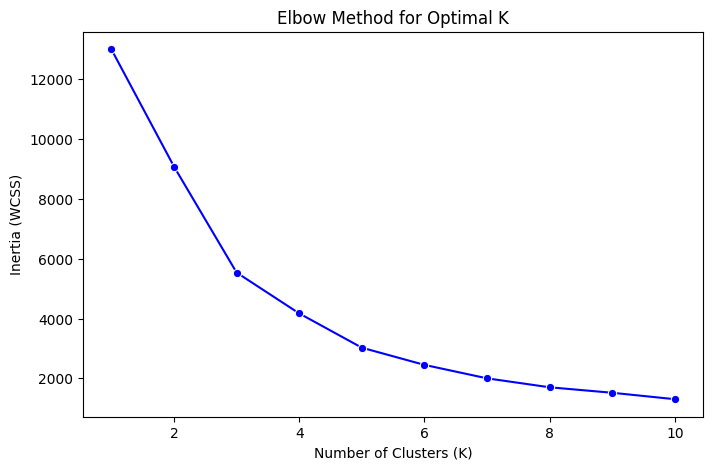

In [586]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features[["Recency", "Frequency", "MonetaryValue"]])

# Finding the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Checking for clusters from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(clustering_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=K_range, y=inertia, marker="o", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [587]:
# Selecting relevant features
features = ["Recency", "Frequency", "MonetaryValue"]
clustering_features = df[features]

# Standardizing the data
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

# Applying K-Means clustering with K=3 (since optimal K was 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(clustering_features_scaled)

# Calculate mean MonetaryValue for each cluster
cluster_means = df.groupby("Cluster")["MonetaryValue"].mean()

# Assign meaningful labels based on spending behavior
cluster_mapping = {
    cluster_means.idxmin(): "Low Purchase",
    cluster_means.idxmax(): "High Purchase"
}

# Assign the remaining cluster as Moderate Purchase
remaining_cluster = [c for c in cluster_means.index if c not in cluster_mapping]
if remaining_cluster:
    cluster_mapping[remaining_cluster[0]] = "Moderate Purchase"

# Map clusters to segments
df["Segment"] = df["Cluster"].map(cluster_mapping)

# Display sample data
df.head(3)


,InvoiceNo,StockCode,Product,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Cluster,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase


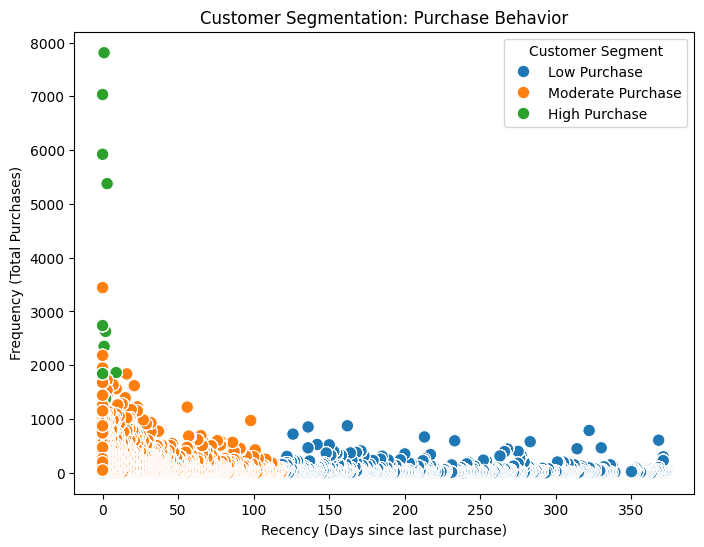

In [588]:
# 2D Scatter Plot (Recency vs Frequency)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Recency", y="Frequency", hue="Segment",s=80)
plt.title("Customer Segmentation: Purchase Behavior")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Frequency (Total Purchases)")
plt.legend(title="Customer Segment")
plt.show()

### Interpretation and Business Insight

The chart helps to understand how customers behave based on Recency(how long ago they made a purchase) and Frequency( how often they buy).

X-axis (Recency): Number of days since a customer last made a purchase. 

Left side(low values): Customers who recently made a purchase.

Right side (high values): Customers who havent bought anything in a long time

Y-axis (Frequency): Total number of purchases

Higher Values: Customers who buy often

Lower Values: Customers who buy less frequently

Customer Segment

Green (High purchase): These are customers who buy frequently and tend to make purchases recently.

Orange (Moderate Purchase): They buy occassionally but are still engaged

Blue (Low Purchase): These customers havent bought in a long time and also dont' purchase often.

Based on the chart, Customers who buy often tend to come back quickly (green cluster). Some customers buy occassionally and have moderate recency (Orange cluster) while many customers haven't bough in a long time and dont buy often (Blue cluster)

### Business Insight

To retain high purchase customers (Green Clusters). The Business can implement a loyalty program or exlcusive discounts to reward them.

For the moderate-purchase customers (Orange clusters), the business can used personalized promotions or email reminders to increase engagement.

Lastly for the Low Purchase Customers (Blue segement), they need to be reactivated. The business can implement re-engagement campaigns with special offers or discounts, use targetted ads or emails to remind them of products they previously showed interest in.

## SUMMARY STATISTICS

In [589]:
df.describe(include=[float, int])

,Quantity,UnitPrice,CustomerID,TotalSales,Year,Quarter,Recency,Frequency,MonetaryValue,Cluster
count,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000,522684.000000
mean,10.640333,3.286658,15291.262143,19.618615,2010.921871,2.834914,41.705440,798.627924,13763.300791,0.289146
std,156.572632,4.461984,1732.501870,269.901414,0.268375,1.136664,68.682913,1468.915069,33943.007282,0.645862
min,1.000000,0.001000,12346.000000,0.001000,2010.000000,1.000000,0.000000,1.000000,3.750000,0.000000
25%,1.000000,1.250000,13819.000000,3.900000,2011.000000,2.000000,3.000000,124.000000,1631.180000,0.000000
50%,4.000000,2.080000,15189.000000,9.900000,2011.000000,3.000000,15.000000,328.000000,4059.820000,0.000000
75%,12.000000,4.130000,16813.000000,17.700000,2011.000000,4.000000,43.000000,741.000000,9213.250000,0.000000
max,80995.000000,649.500000,18287.000000,168469.600000,2011.000000,4.000000,373.000000,7811.000000,281278.790000,2.000000


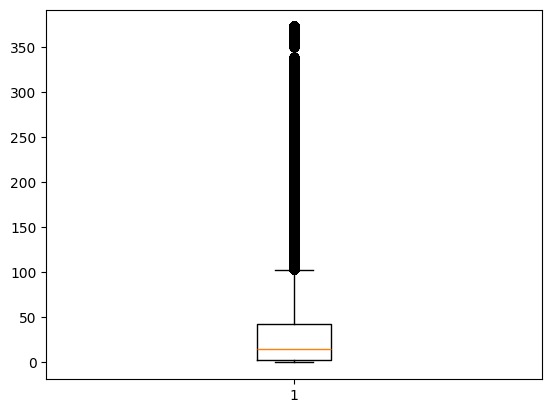

In [590]:
# plotting a boxplot to check for Outliers
plt.boxplot(clustering_features["Recency"])
plt.show()

## PREDICTIVE MODELLING

The aim of this is to build a machine learning model to classify transactions

In [591]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Product', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalSales', 'Year', 'Quarter',
       'Month', 'Period', 'Days_of_Week', 'Recency', 'Frequency',
       'MonetaryValue', 'Cluster', 'Segment'],
      dtype='object')

In [592]:
df1 = df.drop(["InvoiceNo", "StockCode", "Product", "CustomerID", "Quantity", "UnitPrice"], axis = 1)
df1.head()

,InvoiceDate,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Cluster,Segment
0,2010-12-01 08:26:00,United Kingdom,15.30,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
1,2010-12-01 08:26:00,United Kingdom,20.34,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
2,2010-12-01 08:26:00,United Kingdom,22.00,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
3,2010-12-01 08:26:00,United Kingdom,20.34,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase
4,2010-12-01 08:26:00,United Kingdom,20.34,2010,4,December,Morning,Wednesday,371,297,5391.21,2,Low Purchase


In [593]:
df1["Segment"].value_counts()

Segment
Moderate Purchase    426851
Low Purchase          55299
High Purchase         40534
Name: count, dtype: int64

#### *Reasons for the drop:
Dropping these columns remove irrelevant or non-predictive data, reducing noise or overfitting. Retaining features like country, total sales and others captures meaningful patterns and trends for predictive modeling.

### Handling Outliers

I handled the outliers in order not to allow them skew my analysis, distort model performance and lead to incorrect predictions

In [594]:
## Function to calculate lower and upper whiskers
def calculate_whiskers(col):
    q1, q3 = np.percentile(col, [25, 75])
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return lw, uw

In [595]:
num_col = [col for col in df1.select_dtypes(include=['int64', 'float64']).columns if col != "Segment"]
num_col

['TotalSales', 'Recency', 'Frequency', 'MonetaryValue']

In [596]:
## Outlier Handling using winsorization
for i in num_col:
    lw, uw = calculate_whiskers(df1[i])
    df1[i] = np.where(df1[i] < lw, lw, df1[i])
    df1[i] = np.where(df1[i] > uw, uw, df1[i])

In [597]:
df2 = df1.copy()

In [598]:
df1.drop(["InvoiceDate"], axis = 1, inplace = True)

## FEATURE ENCODING

In [599]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# Define the order for 'Month' and 'Days_of_Week'
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[month_order, days_order])
# Initialize LabelEncoders
label_encoder = LabelEncoder()

lbe = ["Country", "Period"]

for col in lbe:
    df1[col] = label_encoder.fit_transform(df1[col])

df1[["Month", "Days_of_Week"]] = ordinal_encoder.fit_transform(df1[["Month", "Days_of_Week"]])



In [600]:
df1.head()

,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Cluster,Segment
0,36,15.30,2010,4,11.0,2,2.0,103.0,297.0,5391.21,2,Low Purchase
1,36,20.34,2010,4,11.0,2,2.0,103.0,297.0,5391.21,2,Low Purchase
2,36,22.00,2010,4,11.0,2,2.0,103.0,297.0,5391.21,2,Low Purchase
3,36,20.34,2010,4,11.0,2,2.0,103.0,297.0,5391.21,2,Low Purchase
4,36,20.34,2010,4,11.0,2,2.0,103.0,297.0,5391.21,2,Low Purchase


## HANDLING IMBALANCE

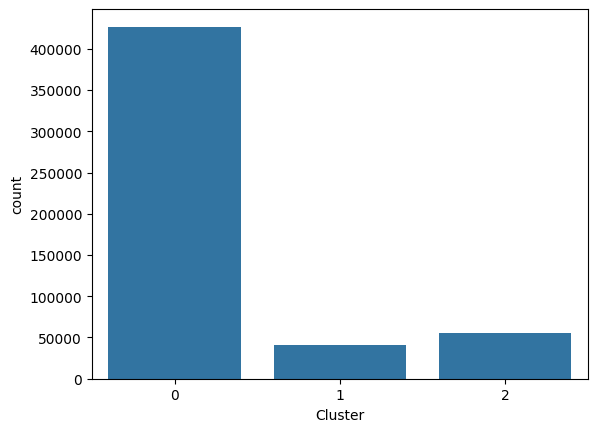

In [601]:
sns.countplot(df1, x = "Cluster")
plt.show()

In [602]:
from sklearn.utils import resample

# Separate classes
df_1 = df1[df1["Cluster"] == 0]  # Minority class
df_2 = df1[df1["Cluster"] == 1]  # Majority class
df_3 = df1[df1["Cluster"] == 2]  # Minority class

min_size = max(len(df_1), len(df_2), len(df_3))  # Get largest class size

df_1_resampled = resample(df_1, replace=True, n_samples=min_size, random_state=42)
df_2_resampled = resample(df_2, replace=True, n_samples=min_size, random_state=42)
df_3_resampled = resample(df_3, replace=True, n_samples=min_size, random_state=42)

df1 = pd.concat([df_1_resampled, df_2_resampled, df_3_resampled]).sample(frac=1, random_state=42)

df1["Cluster"].value_counts()

Cluster
2    426851
0    426851
1    426851
Name: count, dtype: int64

In [603]:
df1.head(3)

,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Cluster,Segment
145466,36,10.20,2011,2,3.0,2,6.0,103.0,135.0,1578.670,2,Low Purchase
201882,36,20.58,2011,2,5.0,0,2.0,22.0,270.0,2820.540,0,Moderate Purchase
133153,36,1.66,2011,1,2.0,0,1.0,2.0,1381.0,20586.355,1,High Purchase


In [604]:
df1["Cluster"].value_counts()

Cluster
2    426851
0    426851
1    426851
Name: count, dtype: int64

## FEATURE SCALING

In [605]:
df1.head()

,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Cluster,Segment
145466,36,10.20,2011,2,3.0,2,6.0,103.0,135.0,1578.670,2,Low Purchase
201882,36,20.58,2011,2,5.0,0,2.0,22.0,270.0,2820.540,0,Moderate Purchase
133153,36,1.66,2011,1,2.0,0,1.0,2.0,1381.0,20586.355,1,High Purchase
127517,36,5.95,2011,1,2.0,0,3.0,103.0,71.0,602.630,2,Low Purchase
146073,36,35.70,2011,2,3.0,0,6.0,103.0,115.0,2222.210,2,Low Purchase


In [606]:
X = df1.drop(columns=["Segment", "Cluster"])
y = df1["Cluster"]

In [607]:
#Checking if they are of the same rows and columns

print(X.shape)
print(y.shape)

(1280553, 10)
(1280553,)


In [608]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [609]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

## MODEL SELECTION

In [610]:

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, confusion_matrix

In [611]:
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, objective="multi:softmax", num_class=3, random_state=42)
model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [612]:
#Train the Model
model.fit(sc_X_train, y_train)
   

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [613]:
#Make Prediction
y_pred = model.predict(sc_X_test)

In [614]:
cluster_mapping = {
    0: "Low Purchase",
    1: "Moderate Purchase",
    2: "High Purchase"
}

y_pred_labels = [cluster_mapping[label] for label in y_pred]

In [615]:
result_df = X_test.copy()  # Copy the test features

result_df["Predicted Cluster"] = y_pred
result_df["Predicted Segment"] = y_pred_labels

result_df.head()

,Country,TotalSales,Year,Quarter,Month,Period,Days_of_Week,Recency,Frequency,MonetaryValue,Predicted Cluster,Predicted Segment
54917,36,11.58,2011,1,0.0,2,4.0,74.0,265.0,2964.530,0,Low Purchase
249987,36,19.96,2011,3,6.0,0,0.0,2.0,1666.5,20586.355,1,Moderate Purchase
200226,36,38.25,2011,2,4.0,2,1.0,103.0,75.0,1594.230,2,High Purchase
253050,36,5.79,2011,3,6.0,0,2.0,103.0,368.0,2745.010,2,High Purchase
490561,36,19.80,2011,4,10.0,2,1.0,10.0,14.0,246.300,0,Low Purchase


In [616]:
## Evaluation
f1 = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")


# print(f"XGboost Model Performance: {name}")
print(f"F1_Score: {f1:.2f}")
print(f"Recall_Score: {recall:.2f}")

F1_Score: 0.99
Recall_Score: 0.99


## FEATURE IMPORTANCE ANALYSIS

This involved choosing the most relevant importantt features (input variables) from my dataset to improve my machine learning model's performance

In [617]:
# Get feature importance
importance = model.feature_importances_

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df

,Feature,Importance
9,MonetaryValue,0.499899
7,Recency,0.426346
8,Frequency,0.019998
2,Year,0.013994
4,Month,0.011045
5,Period,0.008565
0,Country,0.008482
6,Days_of_Week,0.005834
3,Quarter,0.003579
1,TotalSales,0.002257


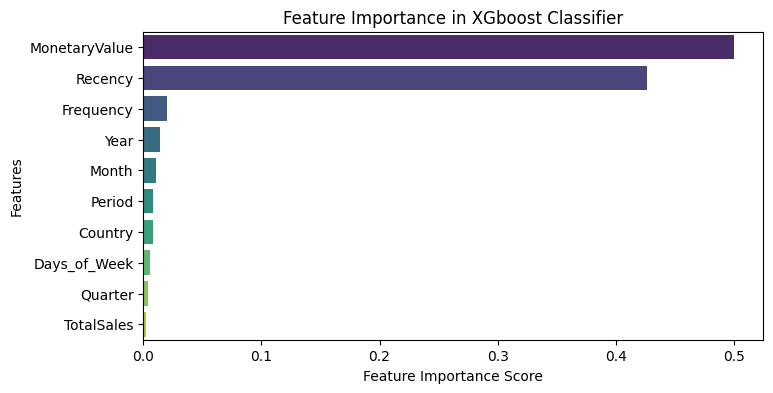

In [618]:
# Plot feature importance using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGboost Classifier")
plt.show()

### Interpretation

The charts shows which factors (features) are most important when predicting customer behavior using XGBoost model.The Longer the bar, the more important the feature.

The chart revealed that Monetary Value (Most important Feature) i.e how much money a customer spends plays a biggest role in preditions. High spending customers are more valuable, so this feature helps in customer segmentation.

Recency:

This refers to how recently a customer made a purchase. if a customer has not bough anything in a long time, they might be at risj of leaving.

Frequency:

This means how often a customer buys is also an important  factor but not as strong as monetary value or recency

Oher Features:

Factors like Year, Month, country and sales periods still matter but dont contribute as much as to predictions

## TIME SERIES ANALYSIS AND SALES FORECASTING


In [619]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Prepare Data
df = df[["InvoiceDate", "TotalSales"]]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date  # Extract only the date part
df = df.groupby("InvoiceDate").agg({"TotalSales": "sum"}).reset_index()
df.columns = ["ds", "y"]  # Prophet requires 'ds' (date) and 'y' (values)
df = df.sort_values("ds").reset_index(drop=True)  # Ensure proper indexing

In [620]:
df

,ds,y
0,2010-12-01,57492.33
1,2010-12-02,47596.42
2,2010-12-03,44788.90
3,2010-12-05,30908.67
4,2010-12-06,51767.12
...,...,...
300,2011-12-05,80061.23
301,2011-12-06,55257.31
302,2011-12-07,72799.09
303,2011-12-08,77562.86


## Split the Data into Train & Test Sets

In [621]:
# Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size].reset_index(drop=True), df.iloc[train_size:].reset_index(drop=True)

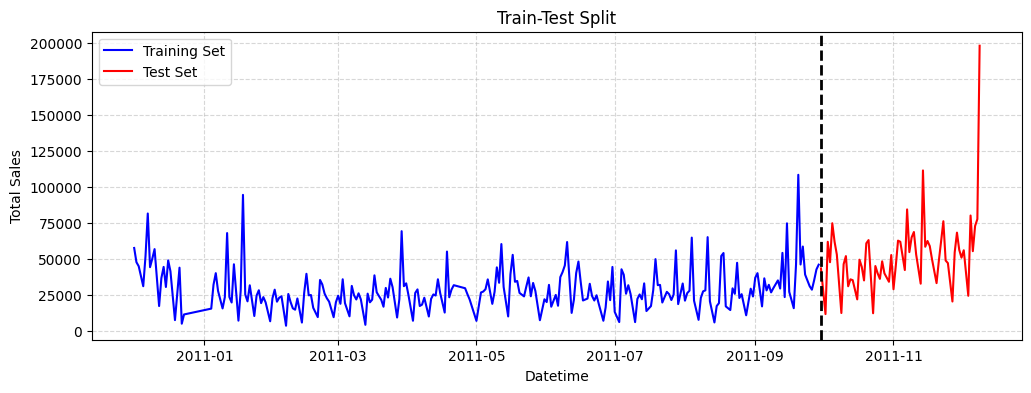

In [622]:
# Train-Test Split Visualization
plt.figure(figsize=(12, 4))
plt.plot(train["ds"], train["y"], label="Training Set", color="blue")
plt.plot(test["ds"], test["y"], label="Test Set", color="red")
plt.axvline(df["ds"].iloc[train_size], color="black", linestyle="--", linewidth=2)  # Split line
plt.xlabel("Datetime")
plt.ylabel("Total Sales")
plt.title("Train-Test Split")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Create Future Dates & Forecast

In [623]:
# Initialize Prophet Model
model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False, 
                seasonality_mode="additive")  # Improved seasonality handling
model.fit(train)

19:01:00 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing


In [624]:
# Generate Future Dates & Predict
future = model.make_future_dataframe(periods=len(test), freq="D")
forecast = model.predict(future)

## Plot the Forecast

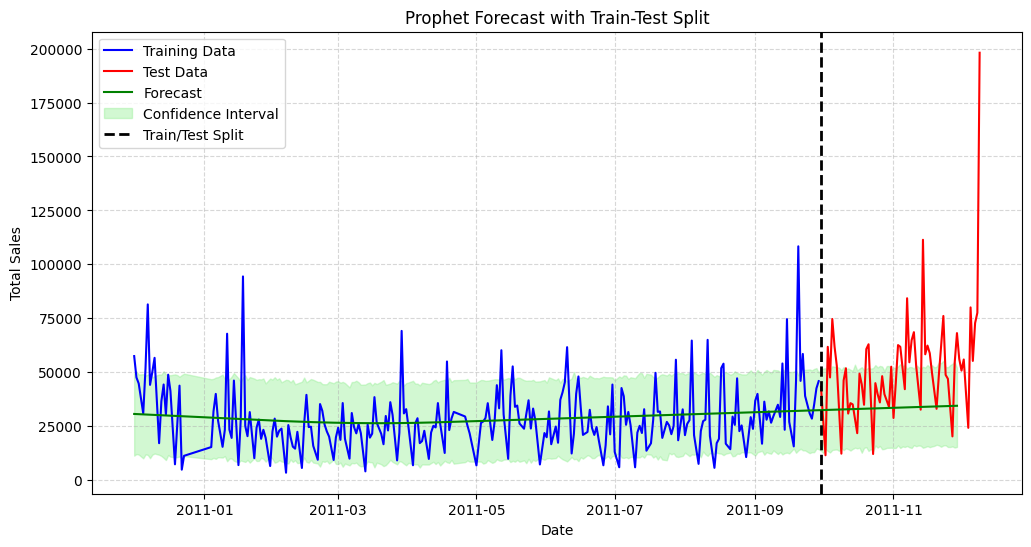

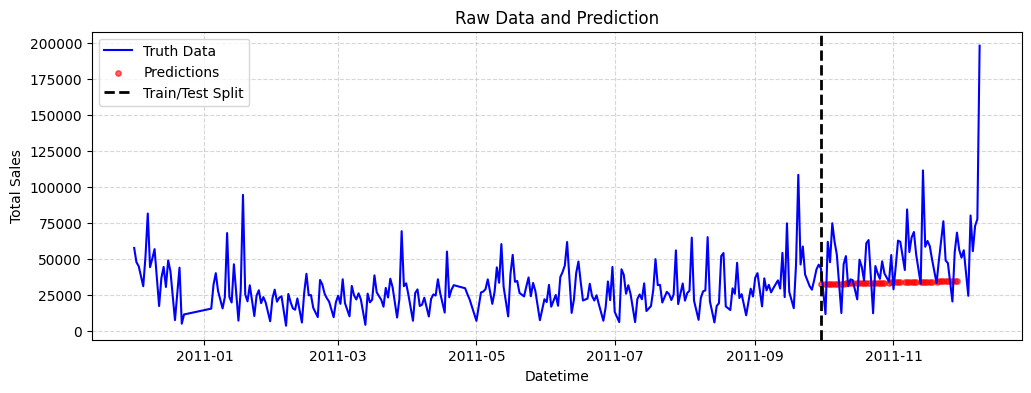

In [625]:
# Create Forecast Plot with Custom Colors
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual (historical) values
ax.plot(train["ds"], train["y"], label="Training Data", color="blue")
ax.plot(test["ds"], test["y"], label="Test Data", color="red")

# Prophet Forecast Line
ax.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="green")

# Uncertainty Interval (Shaded Area)
ax.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], 
                color="lightgreen", alpha=0.4, label="Confidence Interval")

# Formatting
plt.axvline(df["ds"].iloc[train_size], color="black", linestyle="--", linewidth=2, label="Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Prophet Forecast with Train-Test Split")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Extract predictions that match test set dates
test_forecast = forecast.set_index("ds")["yhat"].reindex(test["ds"]).values  # More robust indexing

# Create Figure
plt.figure(figsize=(12, 4))

# Plot Truth Data (Actual Sales in Blue)
plt.plot(df["ds"], df["y"], label="Truth Data", color="blue")

# Plot Predictions (Test Period in Red)
plt.scatter(test["ds"], test_forecast, label="Predictions", color="red", s=15, alpha=0.6)

# Formatting
plt.axvline(df["ds"].iloc[train_size], color="black", linestyle="--", linewidth=2, label="Train/Test Split")
plt.xlabel("Datetime")
plt.ylabel("Total Sales")
plt.title("Raw Data and Prediction")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Interpretation
The time series looks at the past data over time to find patterns. it helps understand how sales have changed historically and whether there are recurring patterns. The Sales Forecasting uses time series analysis (along with machine learning models) to predict future sales.

The Blue Line represents past sales data (actual sales after the model made predictions). 
The red line represents future sales data (actual sales after the model made predictions)
The green shaded area shows the model's confidence interval (how sure it is about its predictions)
The black shaded line seperates past data (training) from future data (testing)
The charts shows that, the online store had fluctuating sales with some months higher than other.
The model predicted sales to stay within a stable range (as seen in the confidence level) but actual sales spiked unexpectedly (likely due to external factors like a holiday season, discounts, viral trends or a special promotion.


## Evaluate the Model

In [628]:
test_forecast = forecast.set_index("ds")["yhat"].reindex(test["ds"]).fillna(method="ffill").values

In [629]:

# Compute Mean Absolute Error
mae = mean_absolute_error(test["y"].values, test_forecast)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 22613.51


### Interpretation

The Mean Absolute Error (MAE) measures the average different between the actual sales values and the predicted values by the mode. A MAE of 22,613.51 means that, on average, the model sales predictions differ from the actual sales by about 22,613 units.

The model accuracy in prediction depends on the scale of the data:

if total sales are in million, an error of 22,613 might not be significant. but if the total sales are much smaller, this error is quite large, meaning the models prediction are not very accurate.

Thus looking at the Total Sales of the business in the past years, 2010 amounted a total sale of 776,240.91 and in 2011 it increased significantly to a total sales of 9,478,095.

Relative to 2010 Sales, an average error of 22,613 is roughly 3% of 776K while relative to 2011 sales (9.48M), an average error of 22,613 is about 0.24% of 9.48M. 

Hence we can conclude that on an annual scale, the model seems reasonably accurate because 22K is a small fraction compared to millions in total sales.


# RECOMMENDATION

The Model

The model gives a baseline forecast for future sales but may not fully capture sudden increases in demand. If the trend continues (with rising sales), the model may need more features (like seasonality, promotions or external events) to make better predictions.